# Importálások

In [1]:
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math
import cv2
import glob
import os
import subprocess
import time
import seaborn as sns
sns.set_theme()

dic = {"xtick.labelsize" : 10, "ytick.labelsize" : 10}

plt.style.use(dic)

xy_s = 25 #x és y label fontsize
t_s = 30 #title fontsize
hs = 0.3 #hspace
ws = 0.25 #wspace

# Főbb függvények

In [142]:
#A merkúr paraméterei
r_ap_Mercury = 0.4667
e_Mercury = 0.2056

class Data:
    e = 0.2056 #Merkúr
    window = np.array([0.1,0.2,0.4,0.2,0.1])
            
    class PlotParams:
    
        def __init__(self,Kepler_Einstein,static_adaptive,stepSize,accuracy,d_0,d,phi):
            if static_adaptive == "RK4":
                self.title = "Merkúr {} {} (stepsize = {:.1e} year)".format(static_adaptive,Kepler_Einstein,stepSize)
            if static_adaptive == "ARK4": 
                self.title = "Merkúr {} {} (accuracy = {:.2e})".format(static_adaptive,Kepler_Einstein,accuracy)
                
            self.xlabel = "x [AU]"
            self.ylabel = "y [AU]"
            self.label1 = "major axis start\n$d={:.2e}$ AU, $\phi=0$ rad".format(d_0)
            self.label2 = "major axis end\n$d={:.2e}$ AU, $\phi={:.2e}$ rad".format(d,phi)
            
    
    def __init__(self,data,Kepler_Einstein,static_adaptive,stepSize=None,accuracy=None):
        
        self.t = data[:,0]
        self.x = data[:,1]
        self.y = data[:,2]
        self.r = data[:,5]
        self.r_smooth = Data.smooth(self.r,Data.window)
        
        self.napt_0 = [data[0,5],0]
        self.d_0 = 2 * self.napt_0[0] / (1 + Data.e) #2a_0
        self.napk_0 = [self.napt_0[0] - self.d_0, 0]
        
        self.mins, self.maxes = Data.find_mins_maxes(self.r_smooth)
        
        self.napk = [self.x[self.mins[-1]],self.y[self.mins[-1]]]
        self.napt = [self.x[self.maxes[-1]],self.y[self.maxes[-1]]]
        self.d = np.sqrt((self.napt[1] - self.napk[1])**2 + (self.napt[0] - self.napk[0])**2)
        self.phi = Data.phi(self.napk,self.napt) # +/- 90°-ig jó, utána nem értelmezhető
        
        try:
            self.dts = data[:,6]
        except:
            pass
            
        self.plotParams = Data.PlotParams(Kepler_Einstein,static_adaptive,
                                          stepSize,accuracy,self.d_0,self.d,self.phi)
    
    @staticmethod
    def phi(vec1,vec2):
        if vec1[0] > vec2[0]:
            return np.arctan((vec1[1] - vec2[1]) / (vec1[0] - vec2[0]))
        else:
            return np.arctan((vec2[1] - vec1[1]) / (vec2[0] - vec1[0]))
    
    @staticmethod
    def smooth(vec,window):
        '''vec és window array, különben nem működik
           a window elemeinek összege 1
           a simítás megőrzi az eredeti hosszt, a vektor elejére és végére a vektor elemeinek átlagát írja'''
        lw = len(window)
        if lw % 2 == 0:
            print("az ablak elemszámának páratlan számúnak kell lennie, most páros került beadásra.")
            print("Nem történt meg a simítás, az eredeti vektor került visszaadásra")
            return vec
        vec_new = [vec[i] for i in range(lw//2)]
        for i in range(lw//2,len(vec)-lw//2):
            vec_new.append(sum(vec[i-lw//2:i+lw//2+1]*window))
        vec_new.extend([vec[i] for i in range(len(vec)-lw//2,len(vec))])
        return np.array(vec_new)
    
    @staticmethod
    def find_mins_maxes(vec):
        mins = []
        maxes = []
        i = 1
        while i < len(vec) - 1:
            if (vec[i-1] >= vec[i] and vec[i] <= vec[i+1]):
                mins.append(i)
                a = vec[i]
                while (a >= vec[i+1] and (i + 1 != len(vec) - 1)):
                    i += 1

            if (vec[i-1] <= vec[i] and vec[i] >= vec[i+1]):
                maxes.append(i)
                a = vec[i]
                while (a <= vec[i+1] and (i + 1 != len(vec) - 1)):
                    i += 1
            i += 1

        if mins == [] or maxes == []:
            print("Hiba, nincsenek minimumok vagy maximumok!")
            return [-1],[-1]

        return mins, maxes
    
#################################################################################################################
#################################################################################################################


def beolvas(filenev,cols_num_read):
    '''Beolvassa a file elérési útvonala alapján annak tartalmát egy numpy két dimenziós arraybe.
       
       Sorok száma a file sorainak száma, oszlopok száma a file oszlopainak száma, az értékek típusa float.'''
    
    f = open(filenev, "r")
    lista=[i.strip().split('\t') for i in f]
    f.close()
    for i in range(len(lista)):
        for j in range(cols_num_read):
            lista[i][j]=float(lista[i][j])
    return np.array(lista)

#################################################################################################################


def create_xy(path,filenames,cols_num_read,cols):
    '''Idősorokat tartalmazó, az oszlopokat egymástól tabbal elválasztó fájlokat olvas be egymás után,
       a megadott oszlopindexek segítségével pedig x-y adatsorokat rendez egynél nagyobb elemszámú 
       listákba, melyeket egy listában ad vissza.
       #####################################################################################################
       Paraméterek:
       
           path            :   fájlok elérési útvonala
           filenames       :   fájlok nevei egy listába rendezve (példa: ["str1.txt","str2.txt"])
           cols_num_read   :   a fájlokban található oszlopok száma (int vagy int lista, példa: [4,5,3])
           cols            :   fájlonként a szükséges oszloppárok listája (példa: [(0,1),(0,2,3),(2,1),(0,3)])
           
       Return:
       
[(x_array1,y_array1_1,...,y_array1_A),(x_array2,y_array2_1,...,y_array2_B),...,(x_arrayn,y_arrayn_1,...,y_arrayn_Z)]'''
    
    if type(cols_num_read) is int:
        cols_num_read = [cols_num_read] * len(filenames)
    
    datas = []
    for i in range(len(filenames)):
        datas.append(beolvas(path+'/'+filenames[i],cols_num_read[i]))
    xy = []
    for datas_i in datas:
        for cols_i in cols:
            sub = []
            for cols_i_j in cols_i:
                sub.append(datas_i[:,cols_i_j])      
            xy.append(sub)
    return xy

#################################################################################################################


def create_args(a,dts,accuracys,path1,path2,src="./kepler.bin",r_ap=r_ap_Mercury,e=e_Mercury,periods=100):
    path1 = path1 + str(a) + ".data"
    path2 = path2 + str(a) + ".data"
    
    args = ["{}".format(src),"{}".format(r_ap),"{}".format(e),"{}".format(periods),"{}".format(dts[a]),"{}".format(accuracys[a]),"{}".format(path1),"{}".format(path2)]
    return args

#################################################################################################################


def create_datas(dts,accuracys,periods,src,path1,path2, Kepler_Einstein="Kepler"):
    
    for i in range(len(dts)):
        subprocess.run(create_args(a=i,dts=dts,accuracys=accuracys,path1=path1,path2=path2,periods=periods,src=src), capture_output=False)
        
    RK4_paths = glob.glob(path1+'*')
    RK4_paths.sort(key=os.path.getmtime)
    
    ARK4_paths = glob.glob(path2+'*')
    ARK4_paths.sort(key=os.path.getmtime)
    
    RK4_datas = [beolvas(path,6) for path in RK4_paths]
    ARK4_datas = [beolvas(path,7) for path in ARK4_paths]
    
    
    RK4_objects = [Data(data=RK4_datas[i],Kepler_Einstein=Kepler_Einstein,
                   static_adaptive="RK4",stepSize=dts[i]) for i in range(len(dts))]
    
    ARK4_objects = [Data(data=ARK4_datas[i],Kepler_Einstein=Kepler_Einstein,
                    static_adaptive="ARK4",accuracy=accuracys[i]) for i in range(len(accuracys))]
    
    return (RK4_objects,ARK4_objects)

#################################################################################################################


def multiplot(RK4,ARK4,save_path,xy_s=50,t_s=60,hs=0.5,ws=0.5):
    
    import seaborn as sns
    sns.set_theme()

    dic = {"xtick.labelsize" : 40, "ytick.labelsize" : 40}

    plt.style.use(dic)
    
    fig, ax = plt.subplots(len(RK4),2,figsize=(50,100))
            
    
    for i in range(len(RK4)):
        
        dt_min = min(ARK4[i].dts)
        dt_max = max(ARK4[i].dts)
        
        ax[i][0].plot(RK4[i].x[:],RK4[i].y[:],'.',markersize=12)
        ax[i][0].plot([RK4[i].napk_0[0],RK4[i].napt_0[0]],
                      [RK4[i].napk_0[1],RK4[i].napt_0[1]],
                      '-o',markersize=35,lw=15,color="orange",label=RK4[i].plotParams.label1)
        ax[i][0].plot([RK4[i].napk[0],RK4[i].napt[0]],
                      [RK4[i].napk[1],RK4[i].napt[1]],'-o',
                      markersize=25,lw=10,color="red",label=RK4[i].plotParams.label2)
        ax[i][0].set_title(RK4[i].plotParams.title,fontsize=t_s)
        ax[i][0].set_xlabel(RK4[i].plotParams.xlabel,fontsize=xy_s)
        ax[i][0].set_ylabel(RK4[i].plotParams.ylabel,fontsize=xy_s)
        ax[i][0].legend(loc="best",fontsize=34)
        
        
        cs = ax[i][1].scatter(ARK4[i].x[:],ARK4[i].y[:],s=40,
                              c=ARK4[i].dts[:],vmin=dt_min,vmax=dt_max)
        ax[i][1].plot([ARK4[i].napk_0[0],ARK4[i].napt_0[0]],
                      [ARK4[i].napk_0[1],ARK4[i].napt_0[1]],
                      '-o',markersize=35,lw=15,color="orange",label=ARK4[i].plotParams.label1)
        ax[i][1].plot([ARK4[i].napk[0],ARK4[i].napt[0]],
                      [ARK4[i].napk[1],ARK4[i].napt[1]],'-o',
                      markersize=25,lw=10,color="red",label=ARK4[i].plotParams.label2)
        ax[i][1].set_title(ARK4[i].plotParams.title,fontsize=t_s)
        ax[i][1].set_xlabel(ARK4[i].plotParams.xlabel,fontsize=xy_s)
        ax[i][1].set_ylabel(ARK4[i].plotParams.ylabel,fontsize=xy_s)
        ax[i][1].legend(loc="best",prop={'size': 34})
        cbar = fig.colorbar(cs,ax=ax[i][1])
        cbar.ax.set_ylabel('$dt$ $[year]$',fontsize = xy_s)
        
    plt.savefig(save_path)
    
#################################################################################################################


def multiplot2(RK4,ARK4,save_path,xy_s=50,t_s=60,hs=0.5,ws=0.5):
    
    import seaborn as sns
    sns.set_theme()

    dic = {"xtick.labelsize" : 40, "ytick.labelsize" : 40}

    plt.style.use(dic)
    
    fig, ax = plt.subplots(len(RK4),2,figsize=(20,40))

    for i in range(len(RK4)):
        dt_min = min(ARK4[i].dts)
        dt_max = max(ARK4[i].dts)
        
        ax[i][0].plot(RK4[i].t[:],RK4[i].r[:],'.',markersize=10)

        ax[i][0].set_title(RK4[i].plotParams.title,fontsize=t_s)
        ax[i][0].set_xlabel("t [year]",fontsize=xy_s)
        ax[i][0].set_ylabel("r [AU]",fontsize=xy_s)
        
        
        cs = ax[i][1].scatter(ARK4[i].t[:],ARK4[i].r[:],s=40,
                              c=ARK4[i].dts[:],vmin=dt_min,vmax=dt_max)
        
        ax[i][1].set_title(ARK4[i].plotParams.title,fontsize=t_s)
        ax[i][1].set_xlabel("t [year]",fontsize=xy_s)
        ax[i][1].set_ylabel("r [AU]",fontsize=xy_s)
        cbar = fig.colorbar(cs,ax=ax[i][1])
        cbar.ax.set_ylabel('$dt$ $[year]$',fontsize = xy_s)
        
    plt.savefig(save_path)
    
#################################################################################################################


#animációs függvény (képek kellenek hozzá)
def save_video(img_name,video_name,speed=10):
    img0=cv2.imread(glob.glob("{}0000.jpg".format(img_name))[0])
    frameSize = (img0.shape[1], img0.shape[0])
    out = cv2.VideoWriter('{}.avi'.format(video_name),cv2.VideoWriter_fourcc(*'DIVX'), speed, frameSize)
    
    for filename in sorted(glob.glob('{}*.jpg'.format(img_name)), key=os.path.getmtime):
        img = cv2.imread(filename)
        out.write(img)
    out.release()

# Első, második és harmadik feladat

In [74]:
#forráskód paraméterek: r_ap, eccentricity, periods, dt, accuracy, path_file_fixed, path_file_adapt

p1 = "./measures/f1/fixed" # fájlokban oszlopok száma 6 (utolsó az r)
p2 = "./measures/f1/adapt" #fájlokban oszlopok száma 7 (utolsó a lépéshossz)

p3 = "./measures/f3/fixed" # fájlokban oszlopok száma 6 (utolsó az r)
p4 = "./measures/f3/adapt" #fájlokban oszlopok száma 7 (utolsó a lépéshossz)

dts = np.array([0.001,0.003,0.006,0.009,0.012])
accuracys = dts ** 2

save_path_Kepler = "./imgs/Kepler_ims.jpg"
save_path_Einstein = "./imgs/Einstein_ims.jpg"

accuracys[0] = 1e-15

RK4_objects_Kepler, ARK4_objects_Kepler = create_datas(dts,accuracys,periods=100,src="./kepler.bin",
                                                       path1=p1,path2=p2)


RK4_objects_Einstein, ARK4_objects_Einstein = create_datas(dts,accuracys,periods=100,src="./einstein.bin",
                                                           path1=p3,path2=p4,Kepler_Einstein="Einstein")

In [143]:
save_path_Kepler = "./imgs/Kepler_ims.jpg"
save_path_Einstein = "./imgs/Einstein_ims.jpg"

In [144]:
#./kepler.bin futtatás során az RK4 és ARK4 módszerek futásidői (cout segítségével leolvasva, manuálisan beírva)
t_RK4 = [0.0804176,0.0297111,0.0149031,0.0125855,0.00750302]
t_ARK4 = [0.493802,0.200693,0.11428,0.0893095,0.0637476]

In [ ]:
# ** 3
t_RK4 = [0.00937463,0.0103852,0.0141892,0.0260316,0.0805773]
t_ARK4 = [0.0283799,0.0333103,0.0416384,0.0611331,0.119067]

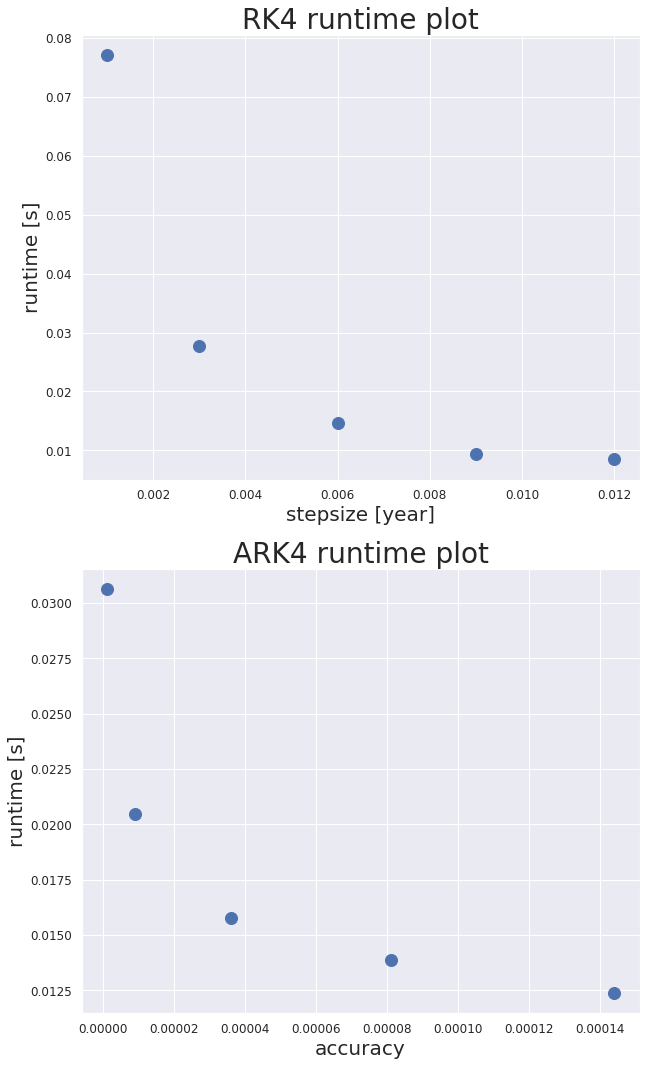

In [62]:
t_RK4 = [0.00847311,0.00930247,0.0146132,0.0277585,0.0770879]
t_ARK4 = [0.0123679,0.0138732,0.0157414,0.0204732,0.0306423]

dic = {"xtick.labelsize" : 12, "ytick.labelsize" : 12}

plt.style.use(dic)

xy_s = 20 #x és y label fontsize
t_s = 28 #title fontsize
hs = 0.3 #hspace
ws = 2 #wspace

fig, ax = plt.subplots(2,1,figsize=(10,18))
ax[0].plot(dts[::-1],t_RK4,'o',markersize=12)
ax[0].set_xlabel("stepsize [year]",fontsize=xy_s)
ax[0].set_ylabel("runtime [s]",fontsize=xy_s)
ax[0].set_title("RK4 runtime plot",fontsize=t_s)

ax[1].plot(dts[::-1]**2,t_ARK4,'o',markersize=12)
ax[1].set_xlabel("accuracy",fontsize=xy_s)
ax[1].set_ylabel("runtime [s]",fontsize=xy_s)
ax[1].set_title("ARK4 runtime plot",fontsize=t_s)

plt.savefig("./imgs/runtime.pdf")

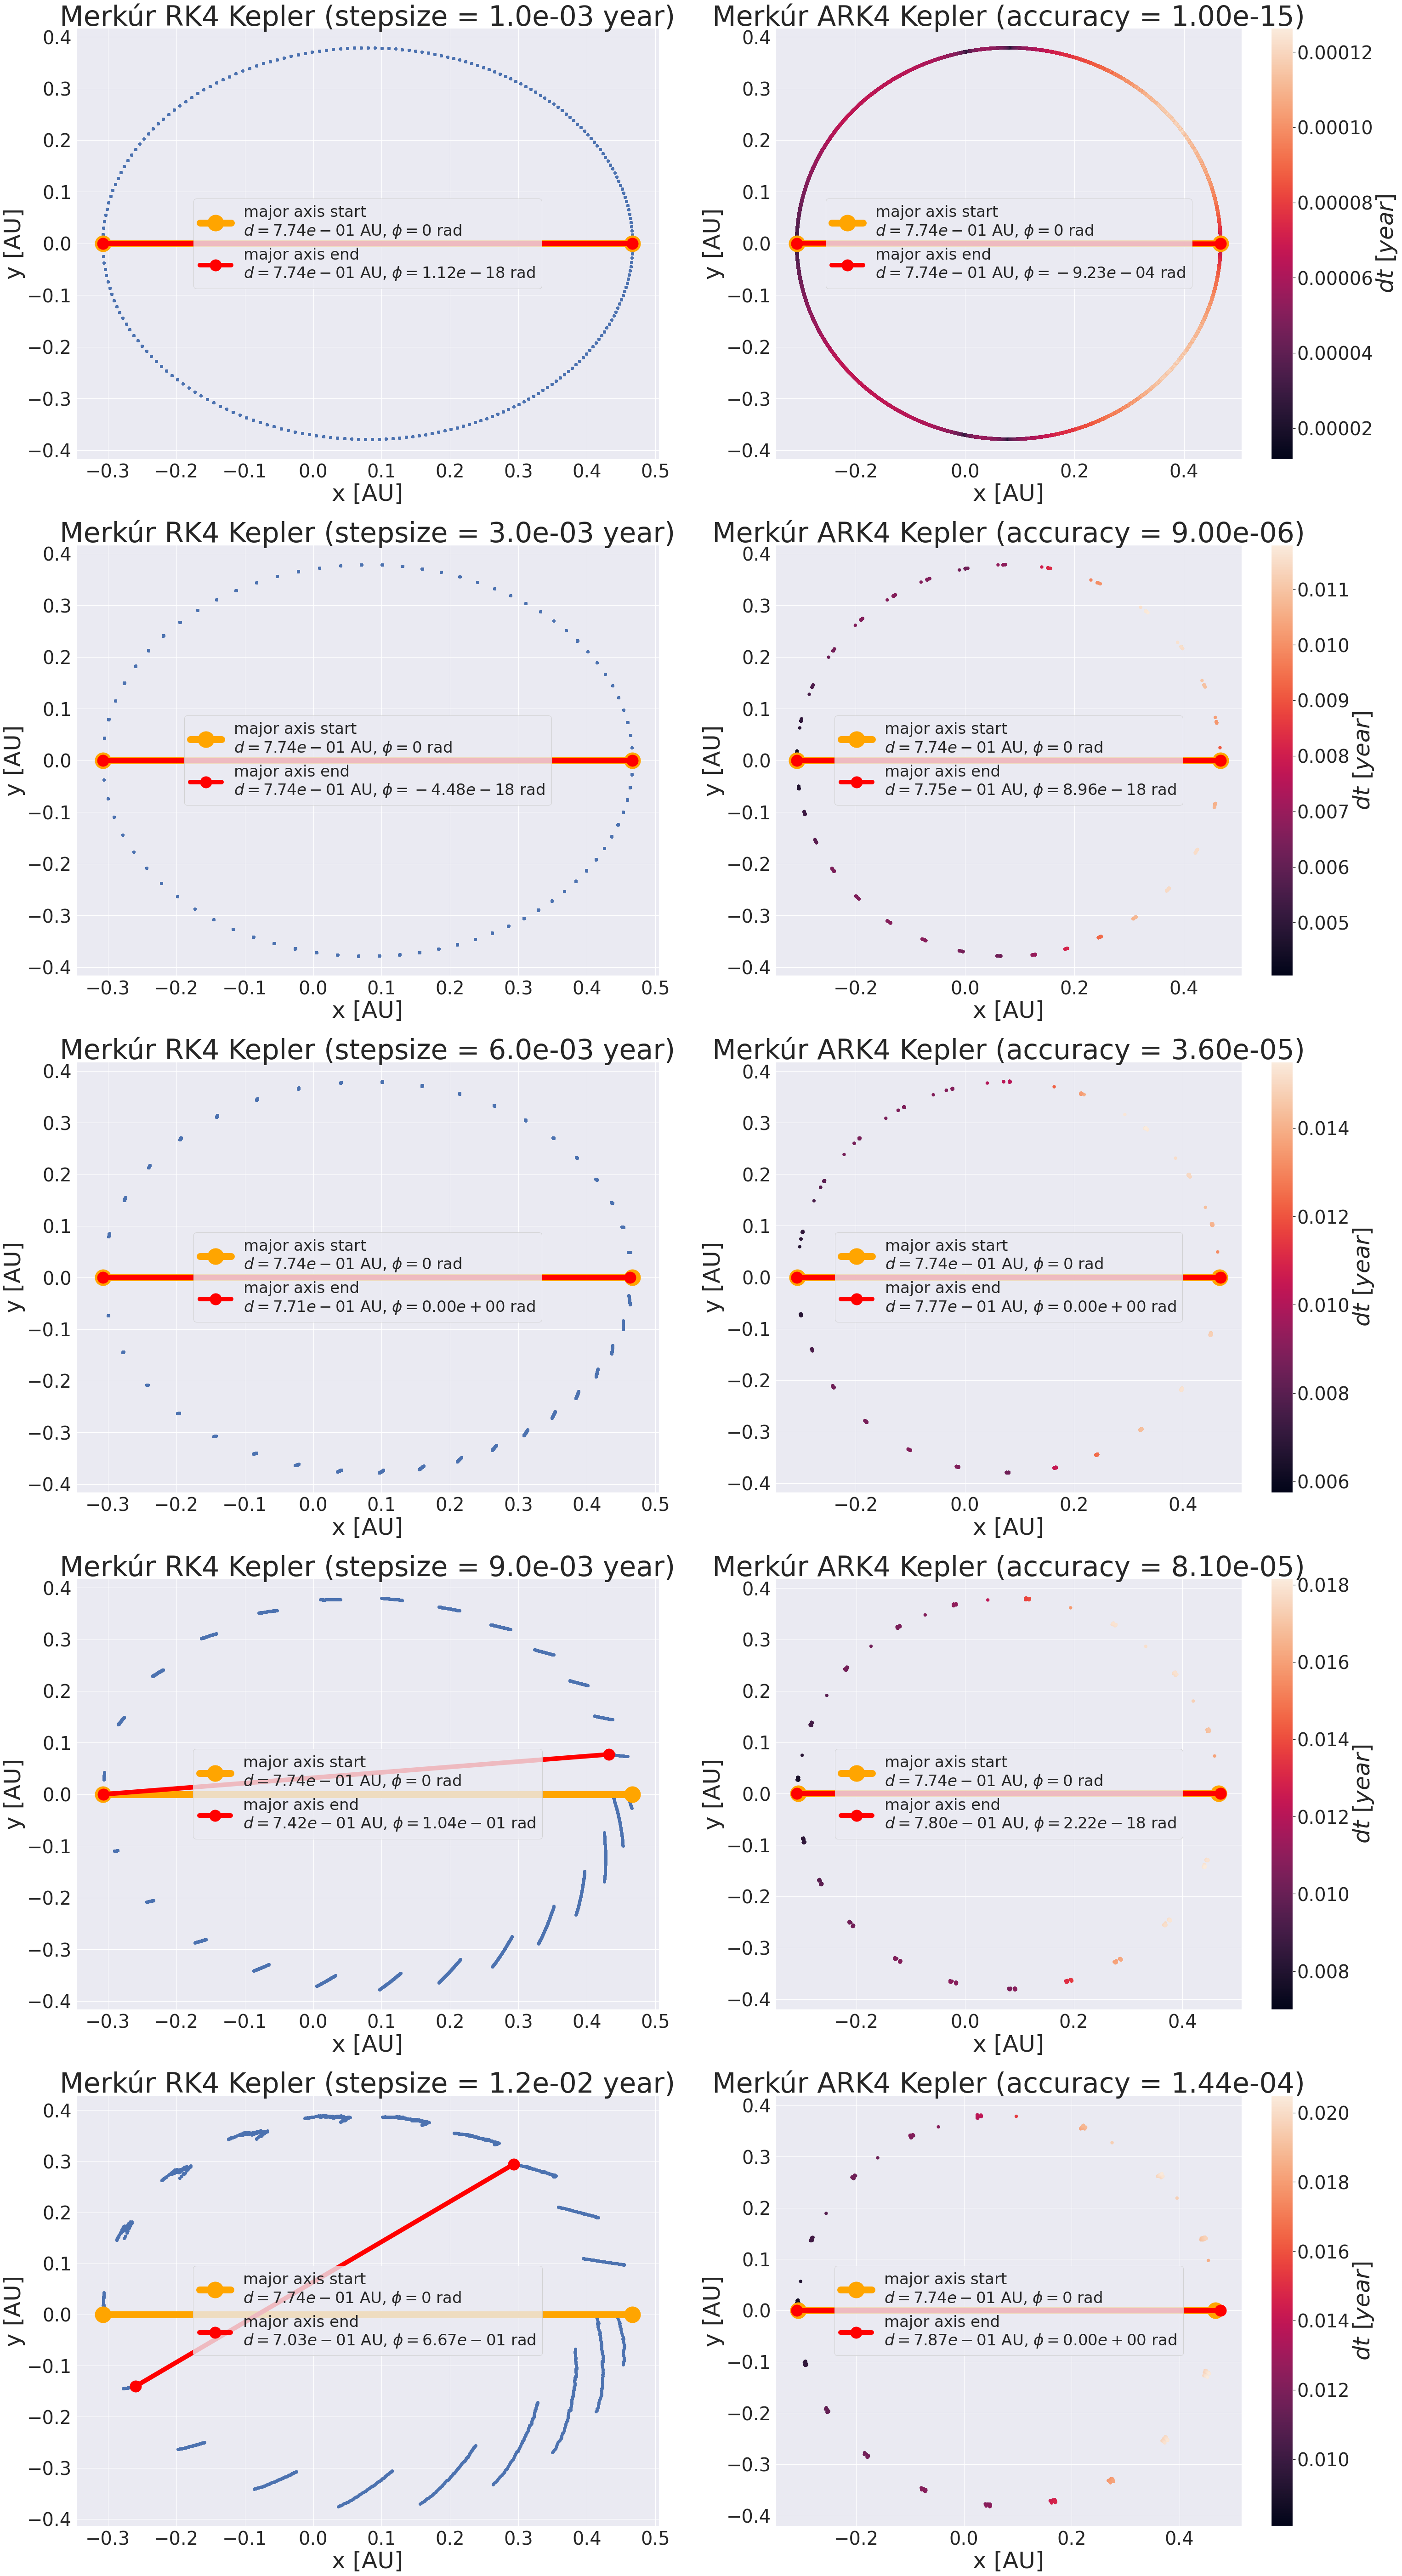

In [145]:
multiplot(RK4_objects_Kepler,ARK4_objects_Kepler,save_path_Kepler)

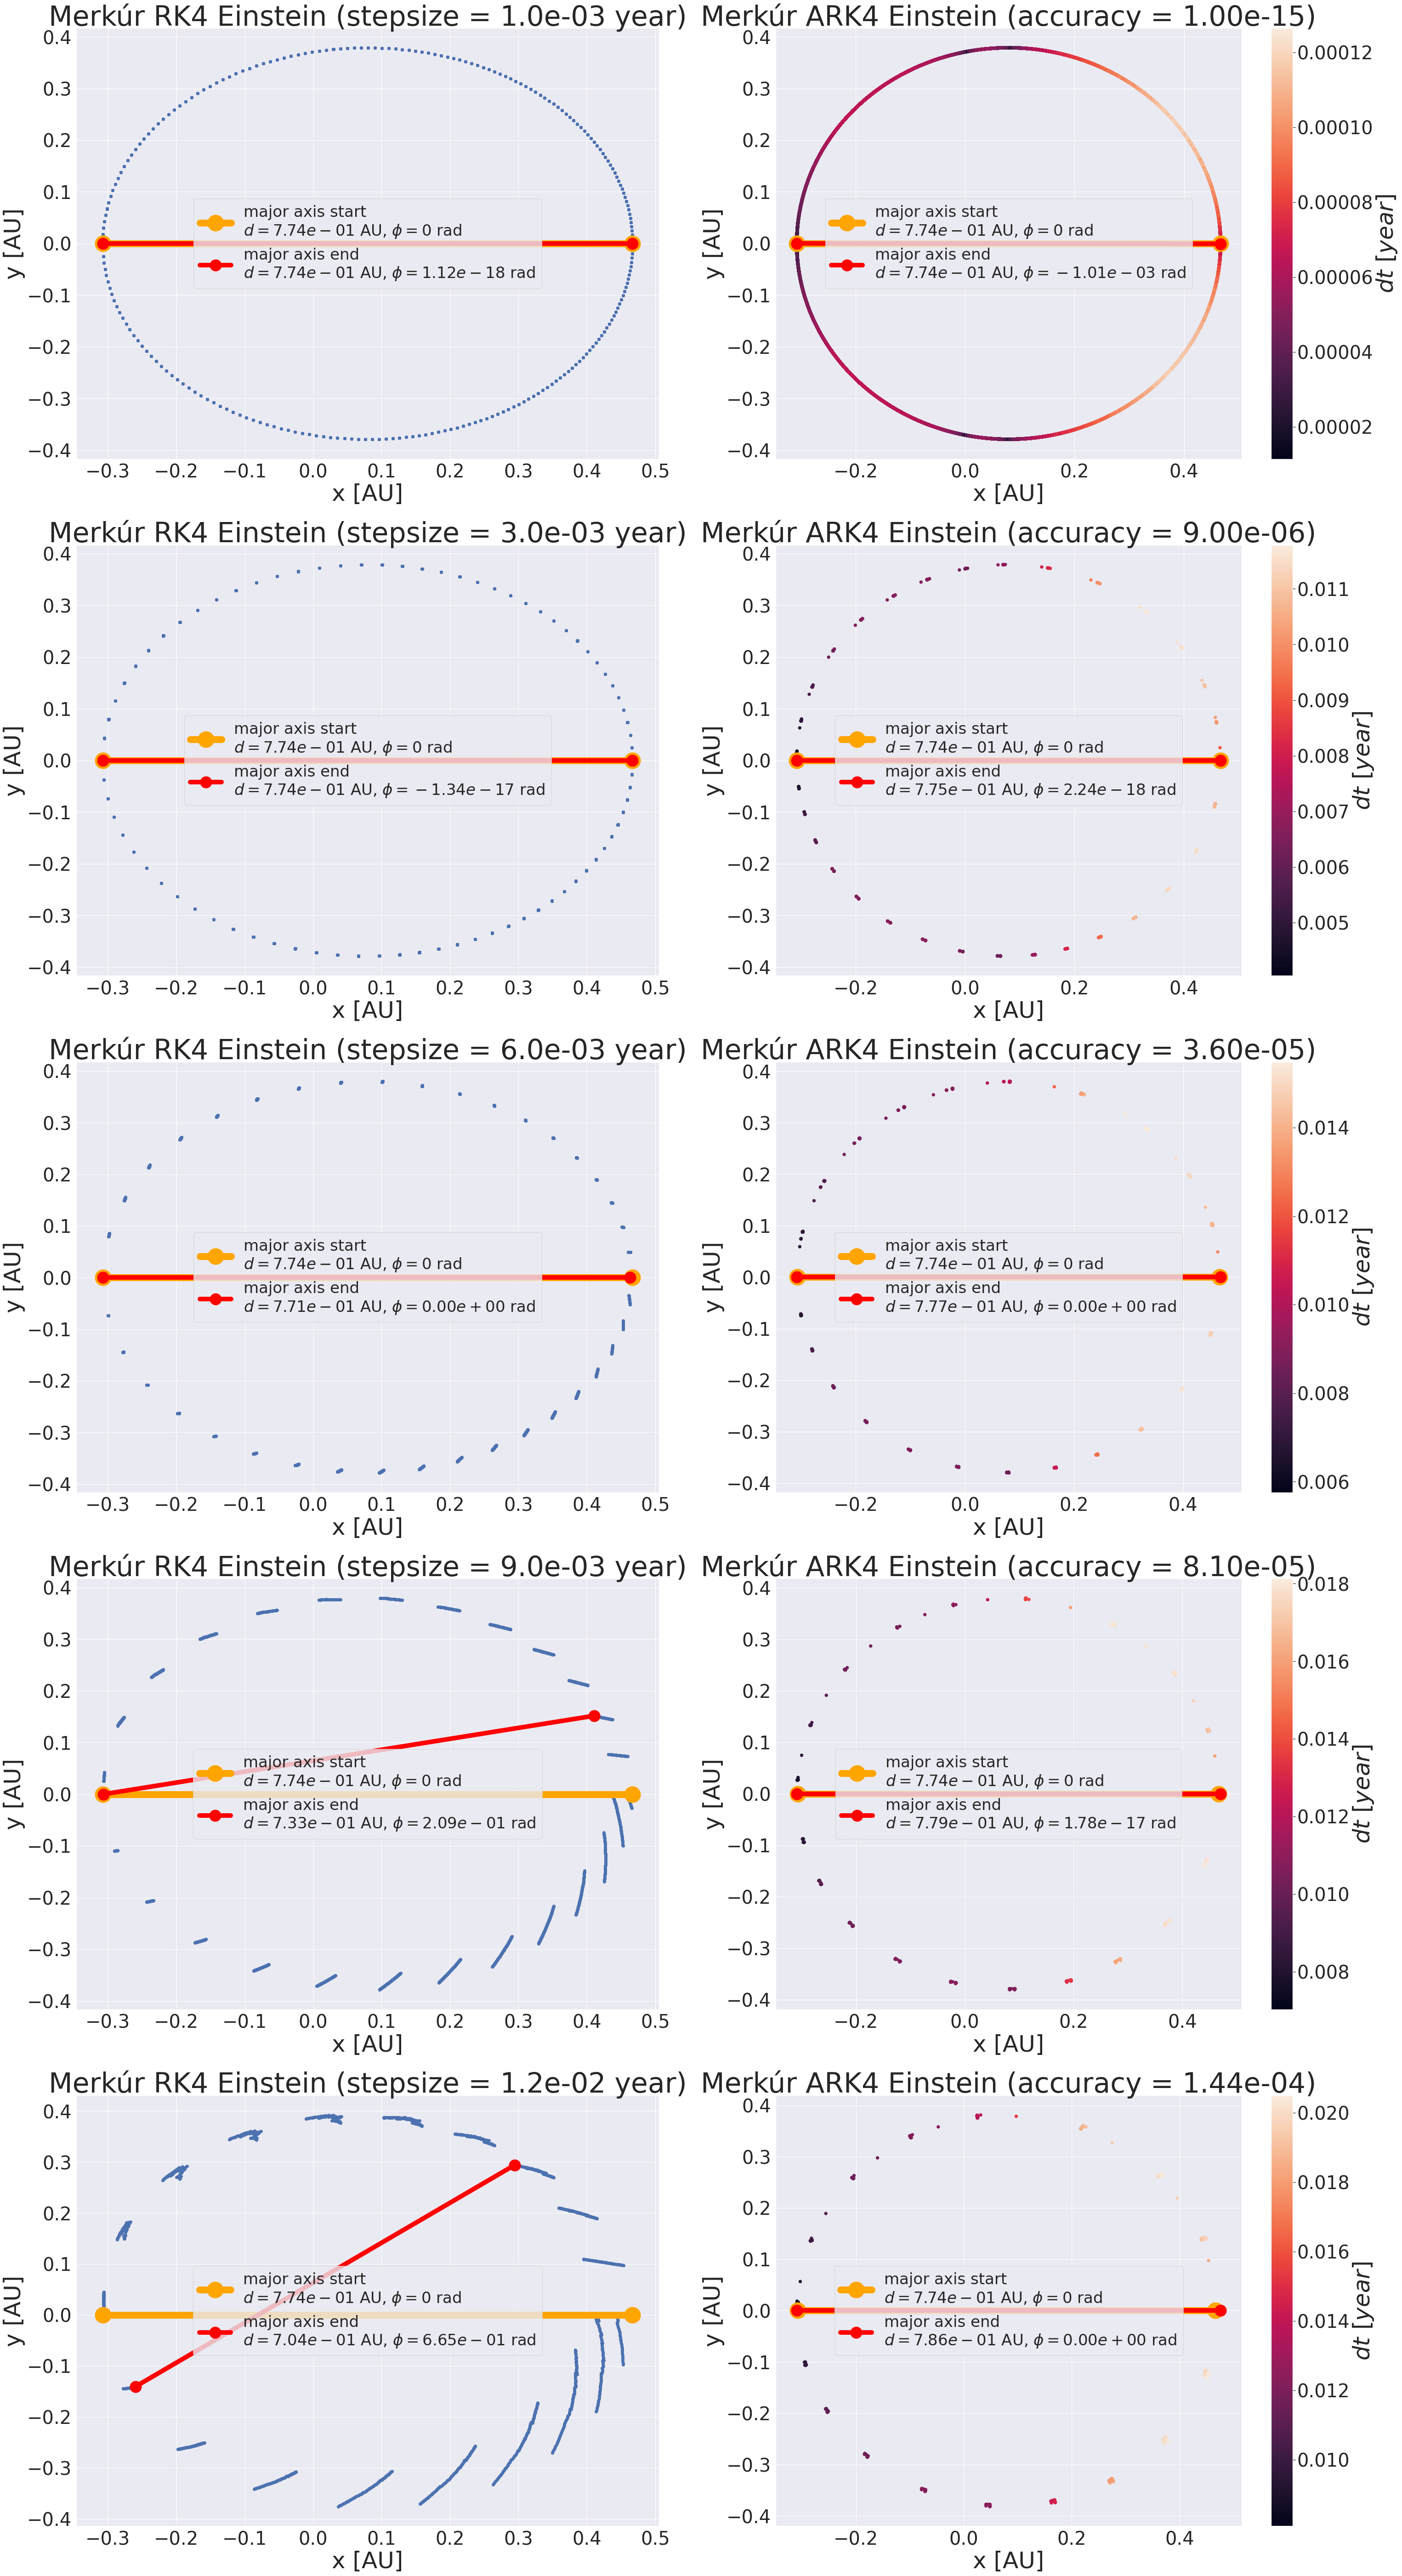

In [146]:
multiplot(RK4_objects_Einstein,ARK4_objects_Einstein,save_path_Einstein)

In [ ]:
save_path_Kepler2 = "./imgs/Kepler_ims2.pdf"
multiplot2(RK4_objects_Kepler,ARK4_objects_Kepler,save_path_Kepler2)

In [ ]:
save_path_Einstein2 = "./imgs/Einstein_ims2.pdf"
multiplot2(RK4_objects_Einstein,ARK4_objects_Einstein,save_path_Einstein2)

# Háromtest probléma

In [222]:
m1 = 331500
m2 = 5*0.1065 # 0.1065
m3 = 0.00002

#5.875

subprocess.run(["./threebody.bin",f"{m1}","0","0","0","0",f"{m2}","1.666","0","0","5.59",f"{m3}","1.66616","0","0","5.8","5","0.002","0.00000001","./measures/f4/static.data","./measures/f4/adapt3b.data"])

CompletedProcess(args=['./threebody.bin', '331500', '0', '0', '0', '0', '0.5325', '1.666', '0', '0', '5.59', '2e-05', '1.66616', '0', '0', '5.8', '5', '0.002', '0.00000001', './measures/f4/static.data', './measures/f4/adapt3b.data'], returncode=0)

-3.22249


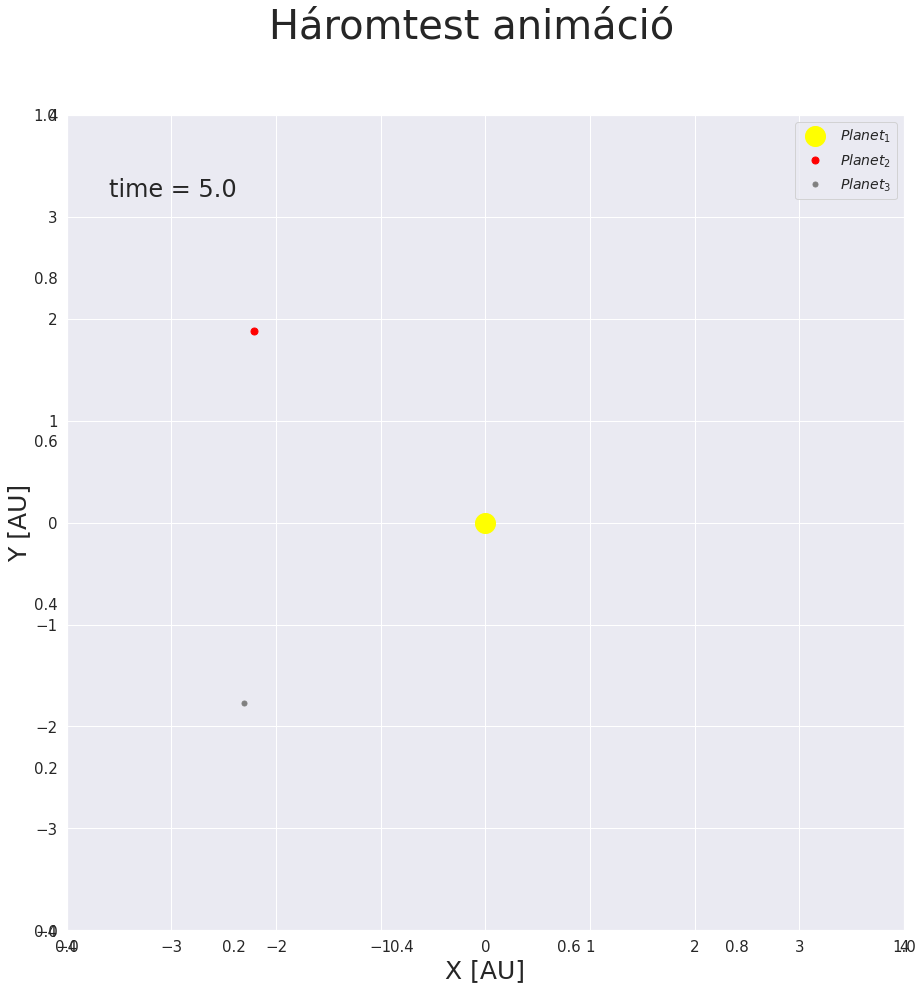

In [224]:
path = "./measures/f4"
double_names = ["adapt3b.data"]
t_x1_y1 = create_xy(path,double_names,13,[(0,1,2)])[0]
t_x2_y2 = create_xy(path,double_names,13,[(0,5,6)])[0]
t_x3_y3 = create_xy(path,double_names,13,[(0,9,10)])[0]

xmin = min(min(t_x1_y1[1]),min(t_x2_y2[1]),min(t_x3_y3[1]))
xmax = max(max(t_x1_y1[1]),max(t_x2_y2[1]),max(t_x3_y3[1]))
ymin = min(min(t_x1_y1[2]),min(t_x2_y2[2]),min(t_x3_y3[2]))
ymax = max(max(t_x1_y1[2]),max(t_x2_y2[2]),max(t_x3_y3[2]))
print(xmin)


dic = {"xtick.labelsize" : 15, "ytick.labelsize" : 15}

plt.style.use(dic)

xy_s = 25 #x és y label fontsize
t_s = 30 #title fontsize
hs = 0.3 #hspace
ws = 0.25 #wspace


fig = plt.figure(figsize=(15,15))
plt.cla()
fig.suptitle("Háromtest animáció",fontsize=40)
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-4, 4), ylim=(-4, 4))
ax.set_xlabel("X [AU]",fontsize=25)
ax.set_ylabel("Y [AU]",fontsize=25)
ax.grid(b=True)

line1, = ax.plot([], [], 'o', color="yellow",markersize = 20, label="$Planet_1$")
line2, = ax.plot([], [], 'o',color="red",markersize = 7, label="$Planet_2$")
line3, = ax.plot([], [], 'o',color="grey",markersize = 5, label="$Planet_3$")

time_template = 'time = %.1f'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes,fontsize=24)

ax.legend(loc="upper right",fontsize=14)

for i in range(len(t_x1_y1[0])):
    line1.set_data(t_x1_y1[1][i], t_x1_y1[2][i])
    line2.set_data(t_x2_y2[1][i], t_x2_y2[2][i])
    line3.set_data(t_x3_y3[1][i], t_x3_y3[2][i])
    
    time_text.set_text(time_template % (t_x1_y1[0][i]))
    plt.savefig("./imgs/animation_imgs/%4.4d.jpg"% (i))

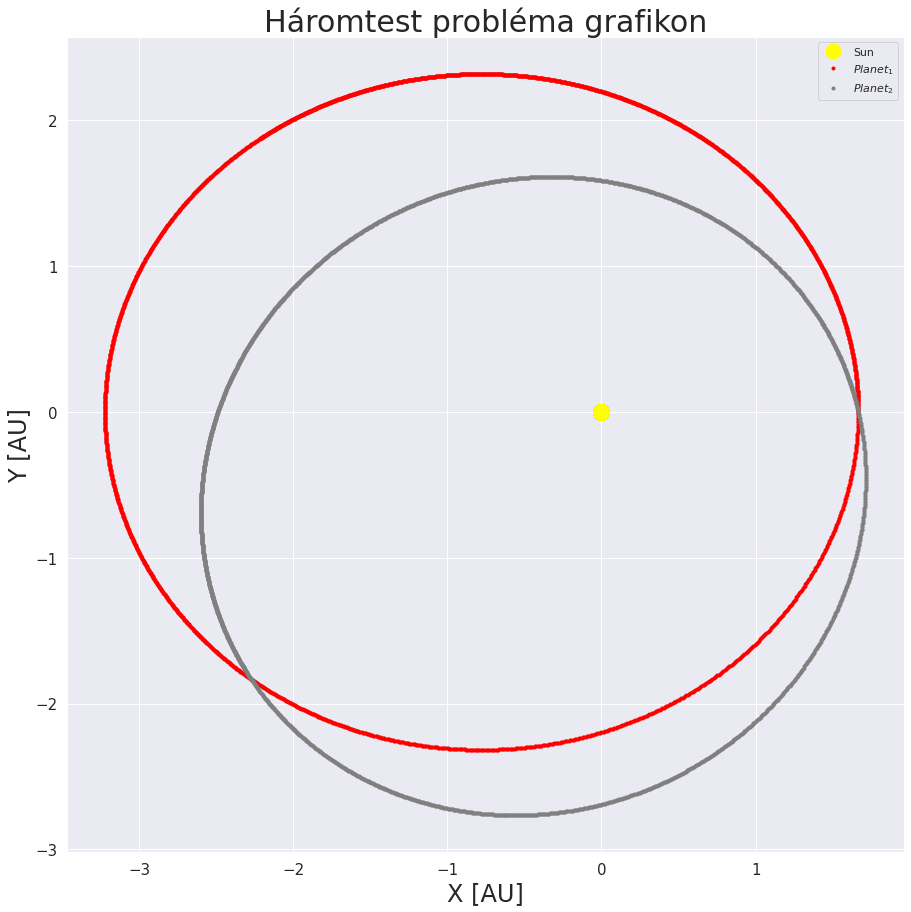

In [229]:
data = beolvas("./measures/f4/adapt3b.data",13)

plt.figure(figsize=(15,15))
plt.plot(data[:,1],data[:,2],'o',markersize=15,color="yellow",label="Sun")
plt.plot(data[:,5],data[:,6],'.',color="red",label="$Planet_1$")
plt.plot(data[:,9],data[:,10],'.',color="grey",label="$Planet_2$")
plt.xlabel("X [AU]", fontsize=24)
plt.ylabel("Y [AU]", fontsize=24)
plt.title("Háromtest probléma grafikon",fontsize=30)
plt.legend()
plt.savefig("./imgs/threebody.jpg")

In [230]:
save_video('./imgs/animation_imgs/',"animation3b",speed=50)